In [0]:
import numpy as np
from numpy.linalg import matrix_power, matrix_rank
# 
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from scipy.integrate import odeint
from scipy.linalg import inv, solve_continuous_are
from math import pi
# 
from scipy.signal import place_poles

A = np.array([
               [0,0,      1,0],
               [0,0,      0,1],
               [0,5.7552, 0,0],
               [0,12.971, 0,0],
])

B = np.array([
               [0],
               [0],
               [0.133],
               [0.111],
])

C = np.array([
              [1, 0, 0, 0],
              [0, 1, 0, 0],
])

# DE solver

In [0]:
def RungeKutta(fnc, x, time):
    Count = time.shape[0]

    n_runge = x.shape[0];

    y = np.zeros((Count, n_runge))
    y[0, :] = x


    for i in range(1, Count-1):
        
        dt = time[i] - time[i-1]
        
        dx1 = fnc(x, time[i])
        dx2 = fnc(x+0.5*dx1*dt, time[i]+dt/2)
        dx3 = fnc(x+0.5*dx2*dt, time[i]+dt/2)
        dx4 = fnc(x+    dx3*dt, time[i]+dt)
        
        dx = (dx1 + 2*dx2 + 2*dx3 + dx4) / 6
        x = x + dx*dt

        
        y[i, :] = x
    return y

# Find observability matrix
$ \mathcal{O} =
  \begin{bmatrix}
  C       \\
  CA      \\
  CA^2    \\
  CA^3
\end{bmatrix}$


In [108]:
O = np.concatenate(
    (
        C, 
        C.dot(A),
        C.dot(matrix_power(A, 2)),
        C.dot(matrix_power(A, 3)),
     )
)

print(f"Observability matrix:\n{O}\n\nShape:{O.shape}\nrank: {matrix_rank(O)}")

Observability matrix:
[[ 1.      0.      0.      0.    ]
 [ 0.      1.      0.      0.    ]
 [ 0.      0.      1.      0.    ]
 [ 0.      0.      0.      1.    ]
 [ 0.      5.7552  0.      0.    ]
 [ 0.     12.971   0.      0.    ]
 [ 0.      0.      0.      5.7552]
 [ 0.      0.      0.     12.971 ]]

Shape:(8, 4)
rank: 4


# Open-loop observer


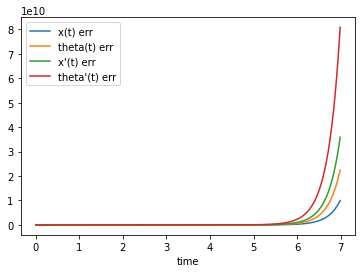

In [109]:
def lqr(A, B, Q, R):
  """
  dx/dt = Ax+ Bu

  J = integral of x.T * Q * x + u.T *R * u
  """
  # solve Algebraic Riccati equation
  S = solve_continuous_are(A, B, Q, R)
  
  # Compute gain 
  K = inv(R).dot( B.T.dot(S) )

  return np.asarray(K)

time_start = 0
time_finish = 7
time_step = 0.01

x_0 = 5
ang_0 = 0
diff_x_0 = 0
diff_ang_0 = pi/8

labels = ["x(t)", "theta(t)", "x'(t)", "theta'(t)"]

time = np.arange(time_start, time_finish, time_step)
init = [x_0, ang_0, diff_x_0, diff_ang_0]

init_obs = [x_0 + 5, ang_0 + pi/6, diff_x_0, diff_ang_0]

Q = np.eye(4) * 100

R = np.eye(1)

k = lqr(A, B, Q, R)

def u(x):
  ret = -k.dot(x)
  return np.array([0])

def differential(x, t):
  Ax = A.dot(x)
  Bu = B.dot(u(x))
  ret = Ax + Bu
  return ret


real = odeint(differential, init, time)
observed = odeint(differential, init_obs, time)
error =  np.absolute(real - observed)

# Print error
# for i in range(real.shape[1]):
#   print(labels[i])
#   for j in range(real.shape[0]):
#     print(f"\tabs({real[j, i]} - {observed[j, i]}) = {error[j, i]}")


plt.plot(time, error)
plt.xlabel('time')

plt.legend(list(map(lambda x: x + " err", labels)))
plt.show()


In [0]:
NOISE_SCALE_OUTPUT = 0.05
NOISE_SCALE_DYNAMICS = 0.05

# NOISE_OUTPUT = False
# NOISE_DYNAMICS = False

# NOISE_OUTPUT = True
# NOISE_DYNAMICS = False

# NOISE_OUTPUT = False
# NOISE_DYNAMICS = True

NOISE_OUTPUT = True
NOISE_DYNAMICS = True

# Luenberg observer

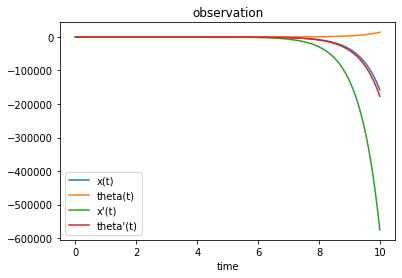

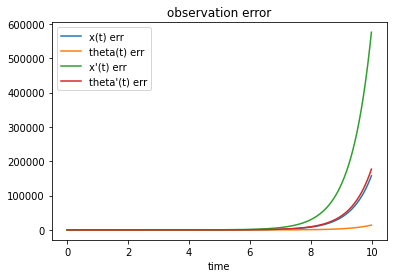

In [117]:
# LQR
Q =  np.array([
                   [1,0,0,0],
                   [0,1,0,0],
                   [0,0,1,0],
                   [0,0,0,1]
])

R = np.array([
              [1, 0],
              [0, 1],
])

L_lqr = lqr(A.T, C.T, Q, R).T

# Pole placement
desired_poles = [-1, -2, -3, -4]
pole = place_poles(A.T, C.T, desired_poles)
L_pole = pole.gain_matrix.T


L = L_lqr  # Change this var to work with calculations of L matrix
k = place_poles(A, B, desired_poles).gain_matrix
def system (x, t):
  ret = (A - B.dot(k)).dot(x)
  # print(ret.shape)
  if NOISE_DYNAMICS:
    ret += NOISE_SCALE_DYNAMICS * np.random.randn(*(ret.shape)) 
    # ret += 0 * np.random.randn(*(ret.shape))
  
  return ret

def luenberg(x_est, t, u, y):
  # x_diff = (x - x_est).reshape((4, 1))
  y_diff = y - C.dot(x_est).reshape((2, ))
  # print(f"C: {C.shape}, x_diff: {x_diff.shape}, y_diff: {y_diff.shape}")

  Ax = A.dot(x_est)
  Bu = B.dot(u).reshape((4, ))
  Ly_diff = L.dot(y_diff)
  # print(f"Ax: {Ax.shape}, Bu: {Bu.shape}, Ly_diff: {Ly_diff.shape}")

  ret = Ax + Bu + Ly_diff
  return ret

time_start = 0
time_finish = 10
time_step = 0.01

x_0 = 0.5
ang_0 = pi/3
diff_x_0 = 0.01
diff_ang_0 = pi/12

x_0_est = 0.5
ang_0_est = pi/6
diff_x_0_est = 0.07
diff_ang_0_est = pi/8

labels = ["x(t)", "theta(t)", "x'(t)", "theta'(t)"]

time = np.arange(time_start, time_finish, time_step)
x = [np.array([x_0, ang_0, diff_x_0, diff_ang_0])]
x_obs = [np.array([x_0_est, ang_0_est, diff_x_0_est, diff_ang_0_est])]
sensor_data = []


for real_x in np.array(list(RungeKutta(system, x[0], time))):
  # This trick with odeint was suggested by students of 4th group in order not to
  # implement custom numeric solver but at the same time pass to the observer
  # values from "sensors"
  local_time = np.array([time[i-1], time[i]])

  x.append(real_x)

  y = C.dot(x[-1])
  if NOISE_OUTPUT:
    y += NOISE_SCALE_OUTPUT * np.random.randn(*(y.shape))
  
  sensor_data.append(y)
  
  u = -k.dot(x_obs[-1])
  # u = np.array([0])  # uncomment to work with uncontrolled
  x_obs_dot = odeint(luenberg, x_obs[-1], local_time, args=(u, y))
  x_obs.append(x_obs_dot[-1])

x = np.array(x)
x_obs = np.array(x_obs)
error = np.absolute(x - x_obs)

plt.plot(time, x_obs[:-1])
plt.title("observation")
plt.xlabel('time')
plt.legend(labels)

plt.show()

plt.plot(time, error[:-1])
plt.xlabel('time')
plt.title("observation error")
plt.legend(list(map(lambda x: x + " err", labels)))
plt.show()



# Kalman Filter

In [0]:
class KalmanFilter():
  def __init__(self, A, C, Q, R, B = None, P = None, x_init = None):

    self.n = A.shape[1]

    self.A = A
    self.B = 0 if B is None else B
    self.C = C
    self.Q = Q
    self.R = R
    self.P = 100 * np.eye(self.n) if P is None else P 
    self.x = np.zeros((self.n, )) if x_init is None else x_init

  def predict(self, u = np.array([0, ])):
    self.x = np.dot(self.A, self.x) + np.dot(self.B, u)
    self.P = np.dot(np.dot(self.A, self.P), self.A.T) + self.Q
    # return self.x

  def update(self, y_sensor):
    y_diff = y_sensor - np.dot(self.C, self.x)
    K_denum = self.R + np.dot(self.C, np.dot(self.P, self.C.T))
    K = np.dot(np.dot(self.P, self.C.T), inv(K_denum))
    self.x = self.x + np.dot(K, y_diff)
    I = np.eye(self.n)
    # print(f"I: {I.shape}, KC: {np.dot(K, C).shape}, P: {self.P.shape}")
    # self.P = np.dot(I - np.dot(K, C), self.P)
    self.P = np.dot(
        np.dot(I - np.dot(K, C), self.P),
        (I - np.dot(K, self.C)).T
    ) + np.dot(np.dot(K, self.R), K.T)
    return self.x

In [0]:
NOISE_SCALE_OUTPUT = 0.05
NOISE_SCALE_DYNAMICS = 0.05

# NOISE_OUTPUT = False
# NOISE_DYNAMICS = False

# NOISE_OUTPUT = True
# NOISE_DYNAMICS = False

# NOISE_OUTPUT = False
# NOISE_DYNAMICS = True

NOISE_OUTPUT = True
NOISE_DYNAMICS = True

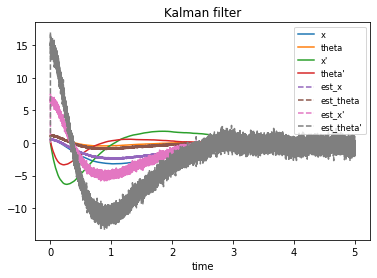

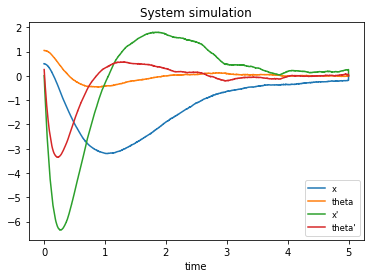

In [0]:
desired_poles = [-1, -2, -3, -4]
k = place_poles(A, B, desired_poles).gain_matrix
def system (x, t):
  ret = (A - B.dot(k)).dot(x)
  # print(ret.shape)
  if NOISE_DYNAMICS:
    ret += 7 * np.random.randn(*(ret.shape)) 
    # ret += 0 * np.random.randn(*(ret.shape))
  
  return ret

time_start = 0
time_finish = 5
time_step = 0.0001
second_stamps = int(1/time_step)

x_0 = 0.5
ang_0 = pi/3
diff_x_0 = 0.01
diff_ang_0 = pi/12

x_0_est = 0.5
ang_0_est = pi/3 + pi/12
diff_x_0_est = 0.02
diff_ang_0_est = pi/13

labels = ["x(t)", "theta(t)", "x'(t)", "theta'(t)"]

time = np.arange(time_start, time_finish, time_step)
x = [np.array([x_0, ang_0, diff_x_0, diff_ang_0])]
x_obs = [np.array([x_0_est, ang_0_est, diff_x_0_est, diff_ang_0_est])]
sensor_data = [C.dot(x[0])]

Q = 10 *   np.array([
                   [1,    0,    0,  0],
                   [0,    1,    0,  0],
                   [0,    0,    1,  0],
                   [0,    0,    0,  1]
])

R = 10 *  np.array([
              [1, 0],
              [0, 1],
])

filter_predictions = [ np.array([x_0_est, ang_0_est, diff_x_0_est, diff_ang_0_est]) ]
kalm_filter = KalmanFilter(A=A, B=B, C=C, Q=Q, R=R, P=None, x_init=filter_predictions[0])

real_x_list=[]
current_time = time_start
time_array = [current_time]
for real_x in np.array(list(RungeKutta(system, x[0], time))):
  real_x_list.append(real_x)

  y = C.dot(real_x)
  if NOISE_OUTPUT:
    y += NOISE_SCALE_OUTPUT * np.random.randn(*(y.shape))
  
  # sensor_data.append(y)
  
  u = -k.dot(filter_predictions[-1])
  kalm_filter.predict()  # here should be also u, but system become instable
  filter_predictions.append(kalm_filter.update(y))


fontP = FontProperties()
fontP.set_size('small')

plt.title("Kalman filter")
x_data = plt.plot(time, real_x_list)
predict_data = plt.plot(time, filter_predictions[:-1], '--')
plt.xlabel('time')
plt.legend([*x_data, *predict_data], ["x", "theta", "x'", "theta'","est_x", "est_theta", "est_x'", "est_theta'"], prop=fontP)
plt.show()

plt.title("System simulation")
plt.plot(time, real_x_list)
plt.xlabel('time')
plt.legend(x_data, ["x", "theta", "x'", "theta'"], prop=fontP)
plt.show()



# LQG

/usr/local/lib/python3.6/dist-packages/scipy/integrate/odepack.py:248: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


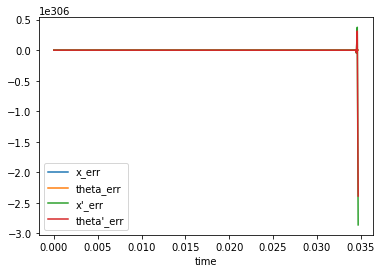

In [0]:
desired_poles = [-1, -2, -3, -4]
k = place_poles(A, B, desired_poles).gain_matrix
def system (x, t):
  ret = (A - B.dot(k)).dot(x)
  # print(ret.shape)
  if NOISE_DYNAMICS:
    ret += NOISE_SCALE_DYNAMICS * np.random.randn(*(ret.shape)) 
    # ret += 0 * np.random.randn(*(ret.shape))

time_start = 0
time_finish = 3
time_step = 0.0001
second_stamps = int(1/time_step)

x_0 = 0.5
ang_0 = pi/3
diff_x_0 = 0.01
diff_ang_0 = pi/12

x_0_est = 0.5
ang_0_est = pi/6
diff_x_0_est = 0.07
diff_ang_0_est = pi/8

labels = ["x(t)", "theta(t)", "x'(t)", "theta'(t)"]

time = np.arange(time_start, time_finish, time_step)
x = [np.array([x_0, ang_0, diff_x_0, diff_ang_0])]
sensor_data = [C.dot(x[0])]

Q =     np.array([
                   [1,    0,    0,  0],
                   [0,    1,    0,  0],
                   [0,    0,    1,  0],
                   [0,    0,    0,  1]
])

R = 0.01 *  np.array([
              [1, 0],
              [0, 1],
])


kalm_filter = KalmanFilter(A=A, B=B, C=C, Q=Q, R=R, P=None, x_init=None)
filter_predictions = [ np.array([x_0_est, ang_0_est, diff_x_0_est, diff_ang_0_est]) ]

for real_x in np.array(list(RungeKutta(system, x[0], time))):
  # This trick was suggested by students of 4th group in order not to
  # implement custom numeric solver but at the same time pass to the observer
  # values from "sensors"
  local_time = np.linspace(time[i-1], time[i])
  u = -k.dot(filter_predictions[-1])
  # u = np.array([0])  # uncomment to work with uncontrolled

  x_dot = odeint(real, x[-1], local_time, args=(u, ))
  x.append(x_dot[-1])

  y = C.dot(x[-1])
  if NOISE_OUTPUT:
    y += NOISE_SCALE_OUTPUT * np.random.randn(*(y.shape))
  
  sensor_data.append(y)
  
  kalm_filter.predict(u)
  filter_predictions.append(kalm_filter.update(y))

x = np.array(x)
prediction_error = plt.plot(time, np.asarray(filter_predictions) - x)

plt.xlabel('time')

plt.legend(iter(prediction_error), ["x_err", "theta_err","x'_err", "theta'_err"])
plt.show()
# filter_predictions